In [1]:
import torch 
import torch.nn as nn 
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision

import matplotlib.pyplot as plt
import numpy as np 

In [2]:
device = None 
if torch.cuda.is_available(): 
    device = "cuda"
else: 
    device = "cpu"

In [3]:
print("DEVICE :", device)

DEVICE : cuda


In [4]:
transform = {
    "train" : transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]), 
    "val" : transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.5,), (0.5,))
    ])
}

In [5]:
batch_size = 64

In [6]:
train_ds = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform["train"])


val_ds = datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform["val"])

Files already downloaded and verified
Files already downloaded and verified


In [7]:
classes = [str(x) for x in range(10)]
print(classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100']


In [8]:
train_size = train_ds.data.shape
val_size = val_ds.data.shape

print("train :", train_size)
print("val :", val_size)

train : (50000, 32, 32, 3)
val : (10000, 32, 32, 3)


In [9]:
train_ds = torch.utils.data.DataLoader(
    train_ds, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4
)


val_ds = torch.utils.data.DataLoader(
    val_ds, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4
)

In [10]:
data = iter(train_ds)
inputs, labels = data.next()

In [11]:
def plot_image(inp, title=None):
    if title is not None: 
        plt.title(f"label : {title}") 
    
    inp = inp.numpy()
    inp = np.transpose(inp, (1, 2, 0))
    inp = inp * 0.5 + 0.5
    plt.imshow(inp)
    return plt.show()


In [12]:
grid = torchvision.utils.make_grid(inputs)

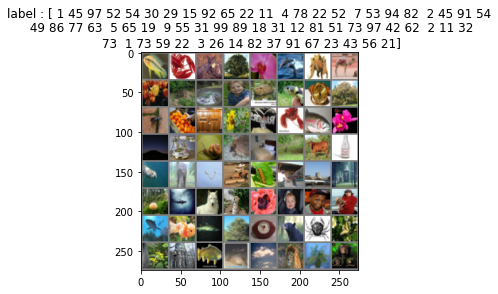

In [13]:
plot_image(grid, labels.numpy())

In [14]:
import torch.nn.functional as F


In [15]:
class ResidualBlock(nn.Module): 
    
    def __init__(self, output_filter,prev_filter, downsample=False): 
        super(ResidualBlock, self).__init__()
        self.downsample = downsample
        self.prev_filter = prev_filter
        self.conv_down = None
        stride = None
        if downsample: 
            stride = 2 
            self.conv_down = torch.nn.Conv2d(prev_filter, output_filter, 1, stride=stride)
        else: 
            stride = 1
        
        self.output_filter = output_filter
        self.conv1 = torch.nn.Conv2d(prev_filter, output_filter, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(output_filter, output_filter, 3, stride=stride, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_filter)
        self.bn2 = torch.nn.BatchNorm2d(output_filter)
        
        
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.downsample: 
            inputs = self.conv_down(inputs)
            inputs = self.bn1(inputs)    
        x = F.relu(inputs + x)
        return x

In [16]:
from torchsummary import summary

block = ResidualBlock(56, 56, downsample=True)
block.to(device)
summary(block, batch_size=batch_size, input_size=(56, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 56, 32, 32]          28,280
       BatchNorm2d-2           [64, 56, 32, 32]             112
            Conv2d-3           [64, 56, 16, 16]          28,280
       BatchNorm2d-4           [64, 56, 16, 16]             112
            Conv2d-5           [64, 56, 16, 16]           3,192
       BatchNorm2d-6           [64, 56, 16, 16]             112
Total params: 60,088
Trainable params: 60,088
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 14.00
Forward/backward pass size (MB): 84.00
Params size (MB): 0.23
Estimated Total Size (MB): 98.23
----------------------------------------------------------------


In [17]:
class ResidualLayer(nn.Module): 
    
    def __init__(self, filter_list, prev_filter, stride=1): 
        super(ResidualLayer, self).__init__()
        self.prev_filter = prev_filter
        self.filter_list = filter_list
        self.stride = stride
        self.layers = self.build_layer()
            
    def build_layer(self): 
        layers = []
        for i in range(len(self.filter_list)): 
            if i == 0 and self.stride == 2: 
                layers.append(ResidualBlock(self.filter_list[i], self.prev_filter, downsample=True))
                self.prev_filter = self.filter_list[i]
            else: 
                layers.append(ResidualBlock(self.filter_list[i], self.prev_filter)) 
                                   
        return nn.Sequential(*layers)
                                   
    def forward(self, x): 
        for layer in self.layers: 
            x = layer(x)
        return x

In [18]:
layer = ResidualLayer([128, 128], 64, stride=2)
layer.to(device)
summary(layer, batch_size=batch_size, input_size=(64, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [64, 128, 32, 32]          73,856
       BatchNorm2d-2          [64, 128, 32, 32]             256
            Conv2d-3          [64, 128, 16, 16]         147,584
       BatchNorm2d-4          [64, 128, 16, 16]             256
            Conv2d-5          [64, 128, 16, 16]           8,320
       BatchNorm2d-6          [64, 128, 16, 16]             256
     ResidualBlock-7          [64, 128, 16, 16]               0
            Conv2d-8          [64, 128, 16, 16]         147,584
       BatchNorm2d-9          [64, 128, 16, 16]             256
           Conv2d-10          [64, 128, 16, 16]         147,584
      BatchNorm2d-11          [64, 128, 16, 16]             256
    ResidualBlock-12          [64, 128, 16, 16]               0
Total params: 526,208
Trainable params: 526,208
Non-trainable params: 0
-------------------------------

In [100]:
class TinyResnet(nn.Module): 
    
    def __init__(self): 
        super(TinyResnet, self).__init__() 
        self.conv1 = torch.nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(16)
        
        self.block1 = ResidualLayer([16, 16], 16)
        self.block2 = ResidualLayer([16, 16] ,16)
        self.block3 = ResidualLayer([16, 16], 16)
        self.block4 = ResidualLayer([32, 32], 16, stride=2)
        self.block5 = ResidualLayer([32, 32], 32)
        self.block6 = ResidualLayer([32, 32], 32)
        self.block7 = ResidualLayer([64, 64], 32, stride=2)
        self.block8 = ResidualLayer([64, 64], 64)
        self.block9 = ResidualLayer([64, 64], 64)
                
        self.avg_pool = torch.nn.AvgPool2d(8)
        self.fc1 = torch.nn.Linear(64, 10)
        
    def forward(self, x): 
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        
        x = self.avg_pool(x).squeeze()
        x = self.fc1(x)
        
        return x

In [101]:
resnet = TinyResnet()
resnet.to(device)
summary(resnet, batch_size=batch_size, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 16, 32, 32]             448
       BatchNorm2d-2           [64, 16, 32, 32]              32
            Conv2d-3           [64, 16, 32, 32]           2,320
       BatchNorm2d-4           [64, 16, 32, 32]              32
            Conv2d-5           [64, 16, 32, 32]           2,320
       BatchNorm2d-6           [64, 16, 32, 32]              32
     ResidualBlock-7           [64, 16, 32, 32]               0
            Conv2d-8           [64, 16, 32, 32]           2,320
       BatchNorm2d-9           [64, 16, 32, 32]              32
           Conv2d-10           [64, 16, 32, 32]           2,320
      BatchNorm2d-11           [64, 16, 32, 32]              32
    ResidualBlock-12           [64, 16, 32, 32]               0
    ResidualLayer-13           [64, 16, 32, 32]               0
           Conv2d-14           [64, 16,

In [102]:
import torch.optim as optim
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
criterion = torch.nn.CrossEntropyLoss()

In [104]:
# training loop
epochs = 15

for epoch in range(epochs): 
    
    current_loss = 0.0
    total = 0 
    corrects = 0
    
    for i, data in enumerate(train_ds): 
        
        # set the existing gradient to 0
        optimizer.zero_grad() 
        
        inputs, labels = data
        
        inputs = inputs.to(device) 
        labels = labels.to(device)
        
        outputs = resnet(inputs) 
        preds = torch.argmax(outputs, dim=1) 
        total += preds.shape[0]
        corrects += (preds == labels).sum().item()
                
        loss = criterion(outputs, labels) 
        current_loss += loss
        
        loss.backward() 
        optimizer.step()
        
        
        if i % batch_size == 0 and i != 0: 
            print(f"BATCH NUMBER {i} | EPOCH {epoch + 1} | LOSS = {current_loss/total} | ACCURACY = {(corrects/total)*100} % ")
            current_loss = 0.0
            corrects = 0
            total = 0
               

BATCH NUMBER 64 | EPOCH 1 | LOSS = 0.07031260430812836 | ACCURACY = 2.620192307692308 % 
BATCH NUMBER 128 | EPOCH 1 | LOSS = 0.06752440333366394 | ACCURACY = 4.736328125 % 
BATCH NUMBER 192 | EPOCH 1 | LOSS = 0.0660591647028923 | ACCURACY = 5.46875 % 
BATCH NUMBER 256 | EPOCH 1 | LOSS = 0.06416450440883636 | ACCURACY = 6.8603515625 % 
BATCH NUMBER 320 | EPOCH 1 | LOSS = 0.06350244581699371 | ACCURACY = 8.056640625 % 
BATCH NUMBER 384 | EPOCH 1 | LOSS = 0.062398359179496765 | ACCURACY = 8.59375 % 
BATCH NUMBER 448 | EPOCH 1 | LOSS = 0.061581384390592575 | ACCURACY = 9.2529296875 % 
BATCH NUMBER 512 | EPOCH 1 | LOSS = 0.06114382669329643 | ACCURACY = 10.0341796875 % 
BATCH NUMBER 576 | EPOCH 1 | LOSS = 0.06038437411189079 | ACCURACY = 10.6201171875 % 
BATCH NUMBER 640 | EPOCH 1 | LOSS = 0.05959687381982803 | ACCURACY = 10.595703125 % 
BATCH NUMBER 704 | EPOCH 1 | LOSS = 0.058911655098199844 | ACCURACY = 11.083984375 % 
BATCH NUMBER 768 | EPOCH 1 | LOSS = 0.05831792950630188 | ACCURACY = 

KeyboardInterrupt: 